<a href="https://colab.research.google.com/github/CianOSull/AutoML_With_SA_FYP_2021/blob/Pycaret/MainNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generic Notebook for running all the libraries

How this notebook works is that it contains the code
for loading and cleaning the dataset.

Then there is multiple branches created on the
Github that include the code for running each library.

E.g. MLBox branch has the code for running MLBox.

# CURRENT BRANCH: PYCARET

# Install the necessary library
Run the install code in the code cell below.

# Second install

Youtube tutorial:

https://www.youtube.com/watch?v=4Rn4YMLUjGc

In [1]:
!pip install pycaret

     |████████████████████████████████| 266kB 11.9MB/s 
     |████████████████████████████████| 2.0MB 16.5MB/s 
     |████████████████████████████████| 102kB 5.1MB/s 
     |████████████████████████████████| 276kB 39.8MB/s 
     |████████████████████████████████| 14.2MB 301kB/s 
     |████████████████████████████████| 215kB 47.4MB/s 
     |████████████████████████████████| 1.7MB 45.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.8MB 37.8MB/s 
     |████████████████████████████████| 61kB 4.1MB/s 
     |████████████████████████████████| 245kB 43.6MB/s 
     |████████████████████████████████| 81kB 6.2MB/s 
     |████████████████████████████████| 61kB 4.5MB/s 
     |████████████████████████████████| 163kB 36.9MB/s 
     |████████████████████████████████| 1.1MB 39.5MB/s 
     |████████████████████████████████| 153kB 54.8MB/s

# Preprocessing Section

In [2]:
# Import the necessary modules for cleaning
import math
import time 
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize 
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [3]:
# Create the set of stopwords for cleaning text
stopwords = set(w.rstrip() for w in open('/content/drive/MyDrive/CIT/FYP/ImplementationFiles/stopwords.txt'))

In [4]:
# Download the necessary parts for the NLTK module
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [5]:
# This funciton handles celaning text
def clean_text(text):
    # Create the lemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    
    # Get rid of non alpha characters except "'" as it is needed for the lemment
    text = "".join(c for c in text if c.isalnum() or c == " " or "'")
    
    # Get rid of capitals
    text = text.lower()
    
    # Tokenize the words    
    # Create tokens of each word
    token_text = word_tokenize(text)
    
    # Get rid of any piece of text that isn't over 2 characters
    token_text = [t for t in token_text if len(t) > 2] 
    
    # Put words in base form by doing lemmatization
    token_text = [wordnet_lemmatizer.lemmatize(t) for t in token_text]

    # Remove stopwords
    token_text = [t for t in token_text if t not in stopwords]
    
    # Return the tokens
    return token_text

In [6]:
# This function will get the term frequencies for word in the review
# TF = Term I frequency in document/total words in document
def calc_tf(term_count, review_corpus):
    # A dictionary of all the term frequencies found
    tf_freq = dict.fromkeys(term_count.keys(), 0)   
    
    # Review corpus is a tokenized list so the total words iteh length
    total_words = len(review_corpus)
    
    # Calculate the term frequency for each word
    for word, count in term_count.items():
        tf_freq[word] = count/total_words
        
    return tf_freq

In [7]:
# This calcualtes the idf
# IDF = log(2)*(Total number of Documents/documents frequency or documents with term)
def calc_idf(unique_terms, list_doc_terms):   
    # A dicitonary of all the inverse document frequencies
    idf = dict.fromkeys(unique_terms, 0)
    
    # Basically list_doc_terms has all the documents with the term count for each word
    # You go through each document count the terms where they occured
    for doc_terms in list_doc_terms:  
        # This for loop is counting the amount of document a word was in
        for word, value in doc_terms.items():
            if 0 < value:
                idf[word] += 1
        
    # Now we calculate idf
    for word, value in idf.items():
        idf[word] = math.log10(10 / float(value))
    
    return idf

In [8]:
# Modified this function to return a list as dictionaries arn't needed anymore
def calc_tf_idf(tf, idf, n_terms):
    # Create an array that is of length of the number of unique terms
    tf_idf_array = np.zeros(n_terms)
    
    for index, (word, value) in enumerate(tf.items()):
        # Add the tfidf to the array
        tf_idf_array[index] = value*idf[word]
    
    return tf_idf_array

In [9]:
def process_text(text_data):
    # A list of all the cleaned reviews
    doc_list = []
    
    # List of all the unique terms
    unique_terms = []
    
    # A list of all the term frequencies
    tf_list = []
    
    for review in text_data:
        # First clean the review
        clean_review = clean_text(review)
        
        # Keeps track of the term counts for each word
        count_dict = {}
        
        # Now lets find the total count for each word
        for token in clean_review:
            if token not in count_dict:
                count_dict[token] = 1
            else:
                count_dict[token] += 1
        
        # Caclulate the term frequencies for each document
        tf_list.append(calc_tf(count_dict, clean_review))
        
        # Then add the dictionary of counts for each document to the list
        doc_list.append(count_dict)
        
        # Then add the new unique terms
        unique_terms = set(unique_terms).union(set(clean_review))
    
    # Calculate the inverse document frequency value
    idf = calc_idf(unique_terms, doc_list)
    
    # This array will contain the tfidf values for each term in each review
    tfidf_values = np.zeros((len(tf_list), len(unique_terms)))
    
    # Now we can get the TFIDF for each document
    for index, term_freq in enumerate(tf_list):
        # This will return an array of the tfidf values calculated.
        # The length of the unique terms list is passed in so that the 
        # Array that is returned matches the tfidf array
        tf_idf_array = calc_tf_idf(term_freq, idf, len(unique_terms))
        # Add this to the overall tfidf values calculated
        tfidf_values[index,:] = tf_idf_array
    
    return tfidf_values

In [10]:
# Prepare the data
def prepare_data(num):
    print("="*50)

    # Load the dataset
    # imdb_df = pd.read_csv("IMDB Dataset.csv")
    imdb_df = pd.read_csv("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/IMDB_Dataset.csv")
    print("Dataset loaded")
    print("="*50)

     # Change each positive and negative value to 1 and 0 respectively    
    imdb_df['sentiment'] = imdb_df['sentiment'].map({'negative' : 0, 'positive' : 1})
    
    # For testing, a much smaller dataset is going to be used
    # imdb_df = imdb_df.head(25000)

    # Group all the negative reviews and get the first 2500
    imdb_df_neg = (imdb_df[imdb_df['sentiment'] == 0])[0:num]
    # imdb_df_neg = (imdb_df[imdb_df['sentiment'] == "negative"])[0:num]
    
    # Group all the positive and get the first 2500
    imdb_df_pos = imdb_df[imdb_df['sentiment'] == 1][0:num]
    # imdb_df_pos = imdb_df[imdb_df['sentiment'] == "positive"][0:num]
    
    # Combine the two split positives and negatives into one dataframe
    imdb_df = pd.concat([imdb_df_neg, imdb_df_pos]) 
    # print(test_df)
    
    # .values on a column of a dataframe returns a numpy array
    # This is a numpy array of all the reviews
    # initial_reviews = imdb_df['review'].values
    initial_reviews = imdb_df['review'].values
    
    # This is a numpy array of all the positive and negativelabels
    # labels = imdb_df['sentiment'].values
    labels = imdb_df['sentiment'].values
    
    print("Creating Feature Vector")
    print("="*50)
    start = time.time()
    # Process the text data and create teh feature vector
    feature_vector = process_text(initial_reviews)
    end = time.time()
    print("Feature Vector Created")
    print(len(feature_vector))
    print(f"Execution time is {end - start} secs")
    print("="*50)
    
    # Shuffle the labesl and feature vector using sklearn shuffle
    feature_vector, labels = shuffle(feature_vector, labels)
    
    # Creating train and test data
    # The splits will be 80:20 
    no_samples = 0.8


    # This gets the percentage of indexes from feature vector and uses those for training
    X_train = feature_vector[0:int(no_samples*len(feature_vector))]
    y_train = labels[0:int(no_samples*len(labels))]
    
    # Go from the index that was used for training to the final
    X_test = feature_vector[int(no_samples*len(feature_vector)):len(feature_vector)]
    y_test = labels[int(no_samples*len(labels)):len(labels)]
    
    return X_train, y_train, X_test, y_test

# Pycaret Code

# Information on runnning classifcation mode

https://pycaret.org/classification/

In [11]:
# Importing data using pandas
import pandas as pd

X_train, y_train, X_test, y_test = prepare_data(500)

print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

# Convert feature_vectors into a pandas dataframe of 
# term frequency inverse document frequency of each word
# tfidf_tf = pd.DataFrame(feature_vector)
tfidf_df_train = pd.DataFrame(columns = ['features', 'labels'])
tfidf_df_test = pd.DataFrame(columns = ['features', 'labels'])

# Add the labels
# tfidf_tf['labels'] = labels

for i in range(len(X_train)):
  tfidf_df_train.loc[i] = [X_train[i].tolist()] + [y_train[i]]

for i in range(len(X_test)):
  tfidf_df_test.loc[i] = [X_test[i].tolist()] + [y_test[i]]


print(tfidf_df_train.head())
print(tfidf_df_test.head())
#==========================================


Dataset loaded
Creating Feature Vector
Feature Vector Created
1000
Execution time is 5.90565824508667 secs
800
800
200
200
                                            features labels
0  [0.011904761904761904, 0.005532212856633684, 0...      1
1  [-0.046102195652093184, -0.052228263346171304,...      1
2  [-0.002641107011409105, -0.0065919167330119105...      0
3  [-0.005566097419584787, 0.005636854873677571, ...      1
4  [0.04183029962242701, -0.004763920032471669, -...      1
                                            features labels
0  [-0.00267946545198217, -0.004616661410354818, ...      1
1  [-0.11700748442633807, 0.022222222222222223, -...      0
2  [0.0029979560758967077, -0.006042676099219179,...      0
3  [-0.027299861753880852, -0.11011206956901215, ...      1
4  [-0.030624919348881504, -0.05673680463513335, ...      0


In [12]:
# Pycaret has few built in functions for machine learning like classifcation
# Importing module and initializing setup
from pycaret.classification import *

In [13]:
# Pycaret always needs to run the setup first
# REMEMBER THAT NEEDS INPUT FROM KEYBOARD TO VERIFY CORRECT INFO
# THIS IS CRASHING
# numeric_features='features',
clf1 = setup(data = tfidf_df_train, target = 'labels')

,Description,Value
0,session_id,2060
1,Target,labels
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(800, 2)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [14]:
best = compare_models(sort = 'AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.4705,0.5262,0.0,0.0000,0.0000,0.0,0.0,0.176
lr,Logistic Regression,0.5295,0.5000,1.0,0.5295,0.6924,0.0,0.0,0.448
knn,K Neighbors Classifier,0.4705,0.5000,0.0,0.0000,0.0000,0.0,0.0,0.264
dt,Decision Tree Classifier,0.5295,0.5000,1.0,0.5295,0.6924,0.0,0.0,0.277
rf,Random Forest Classifier,0.5295,0.5000,1.0,0.5295,0.6924,0.0,0.0,0.851
qda,Quadratic Discriminant Analysis,0.4812,0.5000,0.3,0.1554,0.2047,0.0,0.0,0.221
ada,Ada Boost Classifier,0.5295,0.5000,1.0,0.5295,0.6924,0.0,0.0,0.314
gbc,Gradient Boosting Classifier,0.5295,0.5000,1.0,0.5295,0.6924,0.0,0.0,0.449
lda,Linear Discriminant Analysis,0.5295,0.5000,1.0,0.5295,0.6924,0.0,0.0,0.255
et,Extra Trees Classifier,0.5295,0.5000,1.0,0.5295,0.6924,0.0,0.0,1.046


In [15]:
print("Creating Fit the model")
print("="*50)
start = time.time()
# Create a logistic regression model since it seems to be the best
lr = create_model('lr')
end = time.time()
print("="*50)
print("Model Fitting Finished")
print(f"Execution time is {end - start} secs")
print("="*50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5179,0.5,1.0,0.5179,0.6824,0.0,0.0
1,0.5179,0.5,1.0,0.5179,0.6824,0.0,0.0
2,0.5179,0.5,1.0,0.5179,0.6824,0.0,0.0
3,0.5357,0.5,1.0,0.5357,0.6977,0.0,0.0
4,0.5357,0.5,1.0,0.5357,0.6977,0.0,0.0
5,0.5357,0.5,1.0,0.5357,0.6977,0.0,0.0
6,0.5357,0.5,1.0,0.5357,0.6977,0.0,0.0
7,0.5357,0.5,1.0,0.5357,0.6977,0.0,0.0
8,0.5357,0.5,1.0,0.5357,0.6977,0.0,0.0
9,0.5273,0.5,1.0,0.5273,0.6905,0.0,0.0


Model Fitting Finished
Execution time is 2.4132516384124756 secs


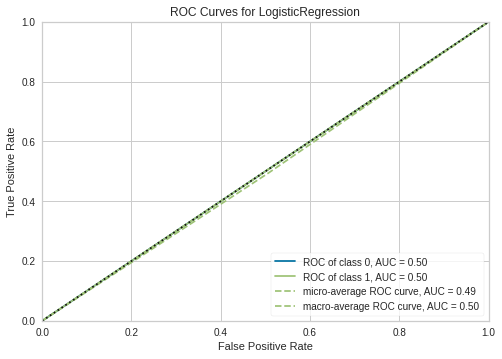

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

Model Fitting Finished
Execution time is 18.735666036605835 secs
Test Accuracy score 0.425


In [16]:
print("Creating Fit the model")
print("="*50)
start = time.time()
# tune hyperparameters to optimize AUC
# tuned_lr = tune_model(lr, optimize = 'AUC') #default is 'Accuracy'
tuned_lr = tune_model(lr) #default is 'Accuracy'
end = time.time()


# Plot a AUC curve of the model 
plot_model(tuned_lr)

# Evaluate the model
evaluate_model(tuned_lr)

# Make some predictions and get the accuracy
lr_pred_new = predict_model(tuned_lr, data = tfidf_df_test)

y_pred = list(lr_pred_new['Label'].values)
y_test = list(tfidf_df_test['labels'].values)
testing_accuracy = accuracy_score(y_test, y_pred)
print("="*50)
print("Model Fitting Finished")
print(f"Execution time is {end - start} secs")
print("="*50)
print("Test Accuracy score {0}".format(testing_accuracy))
    

# Metrics

In [82]:
from sklearn import metrics

# paramters are y_true, y_pred
C = metrics.confusion_matrix(y_test, y_pred)

# lists for the confusion matrix
true_positive = []
true_negative = []
false_postiive = []
false_negatives = []

true_positive.append(C[0,0])
true_negative.append(C[1,1])            
false_postiive.append(C[1,0])
false_negatives.append(C[0,1])

print(C)

print(("="*50))

print("True positives:", round(np.sum(true_positive)/len(y_test), 5), "%")
print("True negatives:", round(np.sum(true_negative)/len(y_test), 5), "%")
print("False positives:", round(np.sum(false_postiive)/len(y_test), 5), "%")
print("False negatives:", round(np.sum(false_negatives)/len(y_test), 5), "%")

[[244   0]
 [256   0]]
True positives: 0.488 %
True negatives: 0.0 %
False positives: 0.512 %
False negatives: 0.0 %


In [83]:
true_positive = C[0,0]
true_negative = C[1,1]            
false_postiive = C[1,0]
false_negatives = C[0,1]

precision = true_positive/(true_positive+false_postiive)
recall = true_positive/(true_positive/false_negatives)

In [77]:
f1_score = (precision*recall)/(precision+recall)

print(f1_score)

nan


In [84]:
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred)

auc = metrics.auc(fpr, tpr)

print("AUC:", auc)

AUC: 0.5


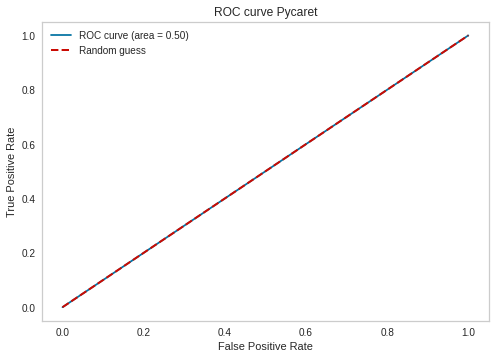

In [85]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC curve Pycaret')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# Output Model

https://pycaret.org/finalize-model/

In [ ]:
# create the best model model
lr = create_model('lr')
# finalize a model
final_rf = finalize_model(lr)

# Other attempts at models

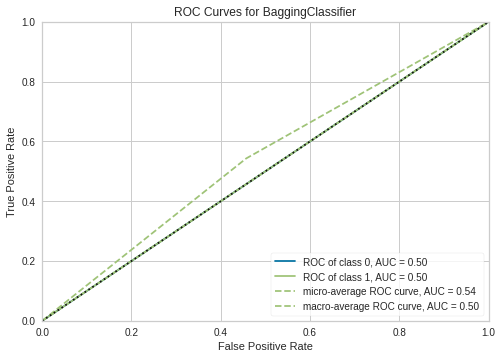

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

Model Fitting Finished
Execution time is 4.056607961654663 secs
Test Accuracy score 0.488


In [40]:
print("Creating Fit the model")
print("="*50)
start = time.time()
# ensemble decision tree model with 'Bagging'
bagged_lr = ensemble_model(lr)
end = time.time()

# Plot a AUC curve of the model 
plot_model(bagged_lr)

# Evaluate the model
evaluate_model(bagged_lr)

# Make some predictions and get the accuracy
lr_pred_new = predict_model(bagged_lr, data = tfidf_df_test)

y_pred = list(lr_pred_new['Label'].values)
y_test = list(tfidf_df_test['labels'].values)
testing_accuracy = accuracy_score(y_test, y_pred)
print("="*50)
print("Model Fitting Finished")
print(f"Execution time is {end - start} secs")
print("="*50)
print("Test Accuracy score {0}".format(testing_accuracy))

In [71]:
from sklearn import metrics

# paramters are y_true, y_pred
C = metrics.confusion_matrix(y_test, y_pred)

# lists for the confusion matrix
true_positive = []
true_negative = []
false_postiive = []
false_negatives = []

true_positive.append(C[0,0])
true_negative.append(C[1,1])            
false_postiive.append(C[1,0])
false_negatives.append(C[0,1])

print(C)

print(("="*50))

print("True positives:", round(np.sum(true_positive)/len(y_test), 5), "%")
print("True negatives:", round(np.sum(true_negative)/len(y_test), 5), "%")
print("False positives:", round(np.sum(false_postiive)/len(y_test), 5), "%")
print("False negatives:", round(np.sum(false_negatives)/len(y_test), 5), "%")

[[  0 244]
 [  0 256]]
True positives: 0.0 %
True negatives: 0.512 %
False positives: 0.0 %
False negatives: 0.488 %


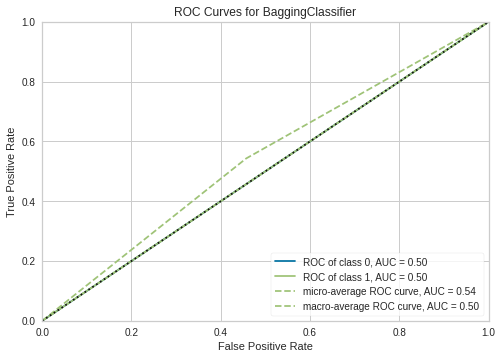

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

Test Accuracy score 0.488
Model Fitting Finished
Execution time is 4.054072856903076 secs


In [41]:
print("Creating Fit the model")
print("="*50)
start = time.time()
# ensemble decision tree model with 'Bagging'
bagged_lr = ensemble_model(lr)
end = time.time()

# Plot a AUC curve of the model 
plot_model(bagged_lr)

# Evaluate the model
evaluate_model(bagged_lr)

# Make some predictions and get the accuracy
lr_pred_new = predict_model(bagged_lr, data = tfidf_df_test)

y_pred = list(lr_pred_new['Label'].values)
y_test = list(tfidf_df_test['labels'].values)
testing_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy score {0}".format(testing_accuracy))
print("="*50)
print("Model Fitting Finished")
print(f"Execution time is {end - start} secs")
print("="*50)


In [72]:
from sklearn import metrics

# paramters are y_true, y_pred
C = metrics.confusion_matrix(y_test, y_pred)

# lists for the confusion matrix
true_positive = []
true_negative = []
false_postiive = []
false_negatives = []

true_positive.append(C[0,0])
true_negative.append(C[1,1])            
false_postiive.append(C[1,0])
false_negatives.append(C[0,1])

print(C)

print(("="*50))

print("True positives:", round(np.sum(true_positive)/len(y_test), 5), "%")
print("True negatives:", round(np.sum(true_negative)/len(y_test), 5), "%")
print("False positives:", round(np.sum(false_postiive)/len(y_test), 5), "%")
print("False negatives:", round(np.sum(false_negatives)/len(y_test), 5), "%")

[[  0 244]
 [  0 256]]
True positives: 0.0 %
True negatives: 0.512 %
False positives: 0.0 %
False negatives: 0.488 %


In [26]:
# Make some predictions and get the accuracy
lr_pred_new = predict_model(tuned_lr, data = tfidf_df_test)

y_pred = list(lr_pred_new['Label'].values)
y_test = list(tfidf_df_test['labels'].values)
testing_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy score {0}".format(testing_accuracy))
    

Test Accuracy score 0.488


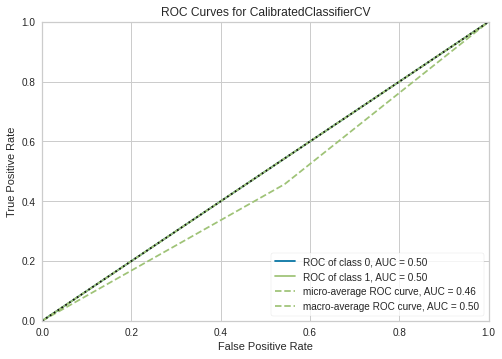

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

Model Fitting Finished
Execution time is 3.5966696739196777 secs
Test Accuracy score 0.512


In [43]:
print("Creating Fit the model")
print("="*50)
start = time.time()
#calibrate trainde boosted dt
calibrated_lr = calibrate_model(lr)
end = time.time()


# Plot a AUC curve of the model 
plot_model(calibrated_lr)

# Evaluate the model
evaluate_model(calibrated_lr)

# Make some predictions and get the accuracy
lr_pred_new = predict_model(calibrated_lr, data = tfidf_df_test)

y_pred = list(lr_pred_new['Label'].values)
y_test = list(tfidf_df_test['labels'].values)
testing_accuracy = accuracy_score(y_test, y_pred)
print("="*50)
print("Model Fitting Finished")
print(f"Execution time is {end - start} secs")
print("="*50)
print("Test Accuracy score {0}".format(testing_accuracy))

In [28]:
best = automl()
print(best)

LogisticRegression(C=7.472, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=482, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [29]:
all_models = models()
print(all_models)

                                     Name  ...  Turbo
ID                                         ...       
lr                    Logistic Regression  ...   True
knn                K Neighbors Classifier  ...   True
nb                            Naive Bayes  ...   True
dt               Decision Tree Classifier  ...   True
svm                   SVM - Linear Kernel  ...   True
rbfsvm                SVM - Radial Kernel  ...  False
gpc           Gaussian Process Classifier  ...  False
mlp                        MLP Classifier  ...  False
ridge                    Ridge Classifier  ...   True
rf               Random Forest Classifier  ...   True
qda       Quadratic Discriminant Analysis  ...   True
ada                  Ada Boost Classifier  ...   True
gbc          Gradient Boosting Classifier  ...   True
lda          Linear Discriminant Analysis  ...   True
et                 Extra Trees Classifier  ...   True
lightgbm  Light Gradient Boosting Machine  ...   True

[16 rows x 3 columns]


In [69]:
print("Keep VM")

Keep VM


# ==============================================================

# Ignore this section

In [ ]:
from pycaret.datasets import get_data
data = get_data('juice') 

from pycaret.classification import *
# REMEMBER THAT YOU HAVE TO ENTER AN INPUT INTO THIS
exp_clf = setup(data, target="Purchase")

,Description,Value
0,session_id,7621
1,Target,Purchase
2,Target Type,Binary
3,Label Encoded,"CH: 0, MM: 1"
4,Original Data,"(1070, 19)"
5,Missing Values,False
6,Numeric Features,13
7,Categorical Features,5
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
# Importing data using pandas
import pandas as pd

feature_vector, labels = prepare_data(500)

# Convert feature_vectors into a pandas dataframe of 
# term frequency inverse document frequency of each word
# tfidf_tf = pd.DataFrame(feature_vector)
tfidf_tf = pd.DataFrame(feature_vector)

# Add the labels
tfidf_tf['labels'] = labels

print(tfidf_tf.head())

#==========================================


Dataset loaded
Creating Feature Vector
Feature Vector Created
1000
Execution time is 3.1326351165771484 secs
          0         1         2         3  ...  18194  18195  18196    labels
0  0.001904 -0.000198  0.004785 -0.004915  ...    0.0    0.0    0.0  positive
1 -0.045806 -0.135172 -0.060521 -0.034925  ...    0.0    0.0    0.0  positive
2 -0.166101 -0.011698 -0.061432 -0.020591  ...    0.0    0.0    0.0  positive
3 -0.002587 -0.014403 -0.453894  0.062500  ...    0.0    0.0    0.0  positive
4  0.002689 -0.094871  0.007066  0.009446  ...    0.0    0.0    0.0  negative

[5 rows x 18198 columns]
